In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
air_quality = pd.read_csv("data/air_quality_no2_long.csv")
air_quality = air_quality.rename(columns={"date.utc": "datetime"})
air_quality.head()

,city,country,datetime,location,parameter,value,unit
0,Paris,FR,2019-06-21 00:00:00+00:00,FR04014,no2,20.0,µg/m³
1,Paris,FR,2019-06-20 23:00:00+00:00,FR04014,no2,21.8,µg/m³
2,Paris,FR,2019-06-20 22:00:00+00:00,FR04014,no2,26.5,µg/m³
3,Paris,FR,2019-06-20 21:00:00+00:00,FR04014,no2,24.9,µg/m³
4,Paris,FR,2019-06-20 20:00:00+00:00,FR04014,no2,21.4,µg/m³


# ¿Cómo manejar datos de series temporales con facilidad?

## 1. Usando las propiedades de fecha y hora de pandas

### 1.1 Quiero trabajar con las fechas en la columna fecha y hora como objetos de fecha y hora en lugar de texto sin formato

In [3]:
air_quality["datetime"] = pd.to_datetime(air_quality["datetime"])
air_quality["datetime"]

0      2019-06-21 00:00:00+00:00
1      2019-06-20 23:00:00+00:00
2      2019-06-20 22:00:00+00:00
3      2019-06-20 21:00:00+00:00
4      2019-06-20 20:00:00+00:00
                  ...           
2063   2019-05-07 06:00:00+00:00
2064   2019-05-07 04:00:00+00:00
2065   2019-05-07 03:00:00+00:00
2066   2019-05-07 02:00:00+00:00
2067   2019-05-07 01:00:00+00:00
Name: datetime, Length: 2068, dtype: datetime64[ns, UTC]

*Observaciones*

Inicialmente, los valores de fecha y hora son cadenas de caracteres y no proporcionan ninguna operación de fecha y hora (por ejemplo, extraer el año, el día de la semana, etc.). Al aplicar la función to_datetime, pandas interpreta las cadenas y las convierte en objetos datetime (es decir, datetime64[ns, UTC]). En pandas llamamos a estos objetos de fecha y hora similares a datetime.datetime de la biblioteca estándar como pandas.Timestamp.

> Nota: Como muchos conjuntos de datos contienen información de fecha y hora en una de las columnas, la función de entrada de pandas como pandas.read_csv() y pandas.read_json() puede hacer la transformación a fechas al leer los datos usando el parámetro parse_dates con una lista de las columnas para leer como marca de tiempo:

`pd.read_csv("../data/air_quality_no2_long.csv", parse_dates=["datetime"])`

¿Por qué son útiles estos objetos pandas.Timestamp? Ilustremos el valor agregado con algunos casos de ejemplo.

> ¿Cuál es la fecha de inicio y finalización del conjunto de datos de la serie temporal con el que estamos trabajando?

In [4]:
air_quality["datetime"].min(), air_quality["datetime"].max()

(Timestamp('2019-05-07 01:00:00+0000', tz='UTC'),
 Timestamp('2019-06-21 00:00:00+0000', tz='UTC'))

*Observaciones*

El uso de pandas.Timestamp para fechas y horas nos permite calcular con información de fechas y hacerlas comparables. Por lo tanto, podemos usar esto para obtener la longitud de nuestra serie temporal:

In [5]:
air_quality["datetime"].max() - air_quality["datetime"].min()

Timedelta('44 days 23:00:00')

*Observaciones*

El resultado es un objeto pandas.Timedelta, similar a datetime.timedelta de la biblioteca estándar de Python y que define una duración de tiempo.

### 1.2 Quiero agregar una nueva columna al DataFrame que contenga solo el mes de la medición

In [6]:
air_quality["month"] = air_quality["datetime"].dt.month
air_quality.head()

,city,country,datetime,location,parameter,value,unit,month
0,Paris,FR,2019-06-21 00:00:00+00:00,FR04014,no2,20.0,µg/m³,6
1,Paris,FR,2019-06-20 23:00:00+00:00,FR04014,no2,21.8,µg/m³,6
2,Paris,FR,2019-06-20 22:00:00+00:00,FR04014,no2,26.5,µg/m³,6
3,Paris,FR,2019-06-20 21:00:00+00:00,FR04014,no2,24.9,µg/m³,6
4,Paris,FR,2019-06-20 20:00:00+00:00,FR04014,no2,21.4,µg/m³,6


*Observaciones*

Al usar objetos de marca de tiempo para las fechas, los pandas proporcionan muchas propiedades relacionadas con el tiempo. Por ejemplo, el mes, pero también el año, la semana del año, el trimestre... Todas estas propiedades son accesibles mediante el descriptor de acceso dt.

### 1.3 ¿Cuál es la concentración promedio de $NO_2$ para cada día de la semana para cada uno de los lugares de medición?

In [7]:
air_quality.groupby(
    [air_quality["datetime"].dt.weekday, "location"]
)["value"].mean()

datetime  location          
0         BETR801               27.875000
          FR04014               24.856250
          London Westminster    23.969697
1         BETR801               22.214286
          FR04014               30.999359
          London Westminster    24.885714
2         BETR801               21.125000
          FR04014               29.165753
          London Westminster    23.460432
3         BETR801               27.500000
          FR04014               28.600690
          London Westminster    24.780142
4         BETR801               28.400000
          FR04014               31.617986
          London Westminster    26.446809
5         BETR801               33.500000
          FR04014               25.266154
          London Westminster    24.977612
6         BETR801               21.896552
          FR04014               23.274306
          London Westminster    24.859155
Name: value, dtype: float64

*Observaciones*

¿Recuerda el patrón dividir-aplicar-combinar proporcionado por groupby del tutorial sobre el cálculo de estadísticas? Aquí, queremos calcular una estadística dada (por ejemplo, la media de NO_2) para cada día de la semana y para cada ubicación de medición. Para agrupar los días de la semana, usamos la propiedad de fecha y hora del día de la semana (con lunes = 0 y domingo = 6) de pandas Timestamp, a la que también se puede acceder mediante el descriptor de acceso dt. La agrupación en ubicaciones y días de la semana se puede hacer para dividir el cálculo de la media en cada una de estas combinaciones.

> Advertencia:
Como estamos trabajando con una serie temporal muy corta en estos ejemplos, ¡el análisis no proporciona un resultado representativo a largo plazo!

### 1.4 Trace el patrón típico de $NO_2$ durante el día de nuestra serie temporal de todas las estaciones juntas. En otras palabras, ¿cuál es el valor promedio para cada hora del día?

Text(0, 0.5, '$NO_2$ (µg/m^3)')

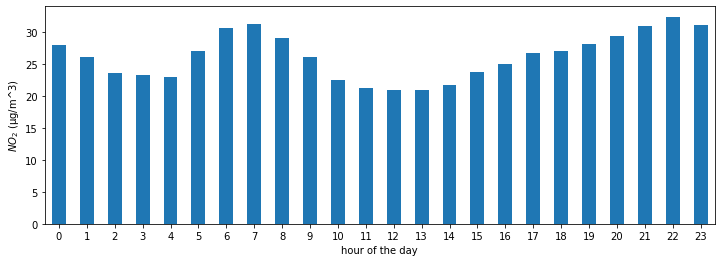

In [13]:
fig, axs = plt.subplots(figsize=(12,4))
air_quality.groupby(
    air_quality["datetime"].dt.hour
)["value"].mean().plot(
    kind='bar', rot=0, ax=axs
)

plt.xlabel("hour of the day"); # custom x label using matplotlib
plt.ylabel("$NO_2$ (µg/m^3)")

Similar al caso anterior, queremos calcular una estadística dada (por ejemplo, la media de $NO_2$) para cada hora del día y podemos usar el enfoque de división, aplicación y combinación nuevamente. Para este caso, usamos la propiedad de fecha y hora hora de pandas Timestamp, a la que también se puede acceder mediante el descriptor de acceso dt.

## 2. Fecha y hora como índice

En el tutorial sobre remodelación, se introdujo pivot() para remodelar la tabla de datos con cada una de las ubicaciones de las medidas como una columna separada:

In [14]:
no_2 = air_quality.pivot(index="datetime", columns="location", values="value")
no_2.head()

location,BETR801,FR04014,London Westminster
datetime,,,
2019-05-07 01:00:00+00:00,50.5,25.0,23.0
2019-05-07 02:00:00+00:00,45.0,27.7,19.0
2019-05-07 03:00:00+00:00,NaN,50.4,19.0
2019-05-07 04:00:00+00:00,NaN,61.9,16.0
2019-05-07 05:00:00+00:00,NaN,72.4,NaN


*Observaciones*

> Nota: Al girar los datos, la información de fecha y hora se convirtió en el índice de la tabla. En general, establecer una columna como índice se puede lograr mediante la función set_index.

Trabajar con un índice de fecha y hora (es decir, DatetimeIndex) proporciona funcionalidades poderosas. Por ejemplo, no necesitamos el descriptor de acceso dt para obtener las propiedades de la serie temporal, pero tenemos estas propiedades disponibles en el índice directamente:

In [15]:
no_2.index.year, no_2.index.weekday

(Int64Index([2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019,
             ...
             2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
            dtype='int64', name='datetime', length=1033),
 Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             ...
             3, 3, 3, 3, 3, 3, 3, 3, 3, 4],
            dtype='int64', name='datetime', length=1033))

*Observaciones*

Algunas otras ventajas son el subconjunto conveniente del período de tiempo o la escala de tiempo adaptada en las parcelas. Apliquemos esto a nuestros datos.

### 2.1 Cree un gráfico de los valores de $NO_2$ en las diferentes estaciones desde el 20 de mayo hasta el final del 21 de mayo

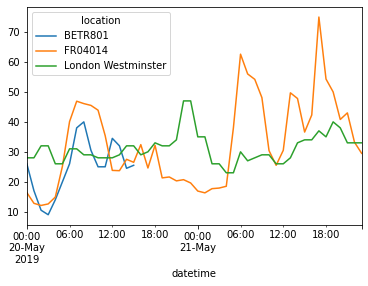

In [16]:
no_2["2019-05-20": "2019-05-21"].plot();

## 3. Remuestrear una serie de tiempo a otra frecuencia

### 3.1 Agregue los valores actuales de la serie temporal horaria al valor máximo mensual en cada una de las estaciones.

In [19]:
monthly_max = no_2.resample("M").max()
monthly_max

location,BETR801,FR04014,London Westminster
datetime,,,
2019-05-31 00:00:00+00:00,74.5,97.0,97.0
2019-06-30 00:00:00+00:00,52.5,84.7,52.0


*Observaciones*

> Algunas otras ventajas son el subconjunto conveniente del período de tiempo o la escala de tiempo adaptada en las parcelas. Apliquemos esto a nuestros datos.

El método resample() es similar a una operación groupby:

* proporciona una agrupación basada en el tiempo, mediante el uso de una cadena (por ejemplo, M, 5H,...) que define la frecuencia objetivo

* requiere una función de agregación como media, máx,...

Cuando se define, la frecuencia de la serie temporal la proporciona el atributo freq:

In [20]:
monthly_max.index.freq

<MonthEnd>

### 3.2 Haz una gráfica del valor medio diario de $NO_2$ en cada una de las estaciones.

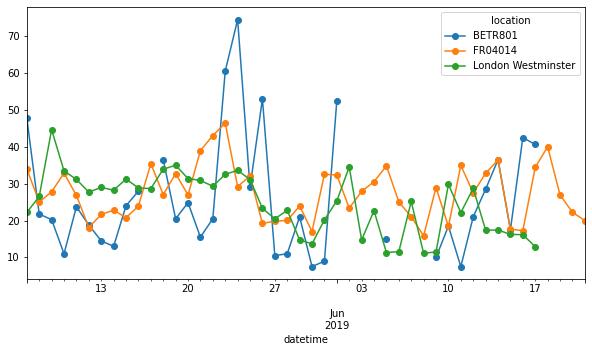

In [22]:
no_2.resample("D").mean().plot(style="-o", figsize=(10,5));

## RECORDAR
* Las cadenas de fecha válidas se pueden convertir en objetos de fecha y hora utilizando la función to_datetime o como parte de las funciones de lectura.

* Los objetos de fecha y hora en pandas admiten cálculos, operaciones lógicas y propiedades convenientes relacionadas con la fecha utilizando el descriptor de acceso dt.

* Un DatetimeIndex contiene estas propiedades relacionadas con la fecha y admite un corte conveniente.

* El remuestreo es un método poderoso para cambiar la frecuencia de una serie temporal.